# Visión por Computadora I - 2025 - B3 - Trabajo práctico 3
**Inteligencia Artificial - CEIA - FIUBA**

## Autores

- **Mendoza Dante**.
- **Vasquez Jorge**.
- **Viñas Gustavo**.

# 💻 TP3 - Parte 1.

(4 puntos) Obtener una detección del logo en cada imagen sin falsos positivos.

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from imutils.object_detection import non_max_suppression

In [2]:
# Lista de imágenes a procesar (incluimos coca_multi.png)
image_files = [
    "images/coca_logo_1.png",
    "images/coca_logo_2.png",
    "images/coca_retro_1.png",
    "images/coca_retro_2.png",
    "images/COCA-COLA-LOGO.jpg",
    "images/logo_1.png",
    "images/coca_multi.png"
]

# Cargamos el template
template = cv2.imread("template/pattern.png", cv2.IMREAD_GRAYSCALE)

In [3]:
def detect(image_file: str, template_scale: float=1., image_scale: float=1., method: int=cv2.TM_CCORR_NORMED):
    # Aplicamos resize al template
    template_resized = cv2.resize(template, None, fx=template_scale, fy=template_scale)
    # Aplicamos Canny al template redimensionado
    template_canny = cv2.Canny(template_resized, 50, 100)
    # Recortamos del template el espacio "vacio" (ajustamos el template al contenido)
    coords = cv2.findNonZero(template_canny) # Find all non-zero points
    x, y, w, h = cv2.boundingRect(coords) # Find minimum spanning bounding box
    p = 2 # Padding alrededor del template (para probar)
    template_canny = template_canny[y-p:y+h+p, x-p:x+w+p]
    tH, tW = template_canny.shape[:2] # Dimensión final del template
    # Graficamos el template
    plt.figure(figsize=(4, 3))
    plt.imshow(template_canny, cmap="gray")
    plt.title("Template")
    plt.show()

    # Cargamos la imagen
    img = cv2.imread(image_file)
    # Verificamos las relación respecto al template
    scale_x = template_resized.shape[1] / img.shape[1]
    scale_y = template_resized.shape[0] / img.shape[0]
    # Valor mayor a 1 indica que el template es mas grande que la imagen en algún sentido
    scale_img = max(scale_x, scale_y)
    # Por mas que se indique por parámetro, no podemos ajustar mas allá del tamaño del template
    scale_img = max(scale_img, image_scale)
    # Reescalo si es necesario, o si es indicado por parámetro
    if (scale_img != 1):
        img = cv2.resize(img, None, fx=scale_img, fy=scale_img)
    # Convertimos a grises
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Aplicamos Canny a la imagen redimensionada
    img_canny = cv2.Canny(img_gray, 200, 300)

    # Aplicamos match template
    result = cv2.matchTemplate(img_canny, template_canny, method)
    # Encontramos los valores máximos y mínimos
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)
    val = min_val if method in [cv2.TM_SQDIFF, cv2.TM_SQDIFF_NORMED] else max_val
    loc = min_loc if method in [cv2.TM_SQDIFF, cv2.TM_SQDIFF_NORMED] else max_loc
    # Dibujamos el rectángulo detectado
    cv2.rectangle(img, (loc[0], loc[1]), (loc[0] + tW, loc[1] + tH), (0, 255, 0), 2)
    # Y el valor de confianza
    cv2.putText(img, f"{val:.2f}", (loc[0], loc[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

    # Mostramos la imagen final
    fig, axs = plt.subplots(1, 2, constrained_layout=True)
    axs[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axs[1].imshow(img_canny, cmap="gray")
    fig.suptitle(f"{image_file} - Score: {val:.3f}")
    # plt.tight_layout()
    plt.show()

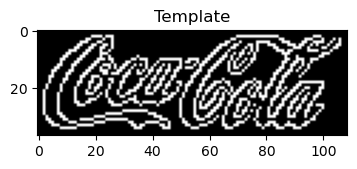

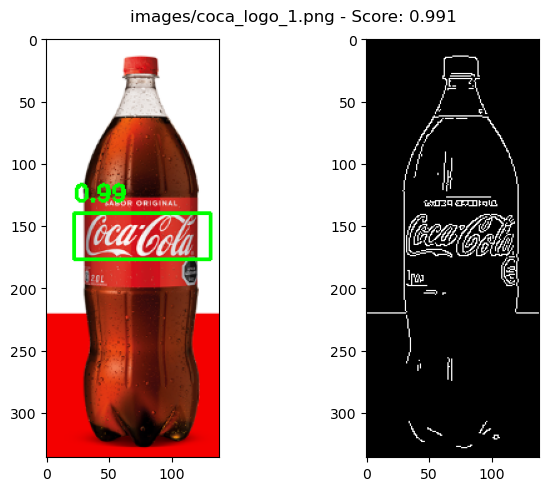

In [4]:
# Detección sobre imagen 1
detect(image_files[0], template_scale=0.28, image_scale=0.673, method=cv2.TM_SQDIFF_NORMED)
# detect(image_files[0], template_scale=0.28, image_scale=0.673, method=cv2.TM_SQDIFF_NORMED) # 0.99
# detect(image_files[0], template_scale=0.3, image_scale=0.7, method=cv2.TM_SQDIFF_NORMED) # 0.97
# detect(image_files[0], template_scale=0.22, image_scale=0.5, method=cv2.TM_SQDIFF_NORMED) # 0.92

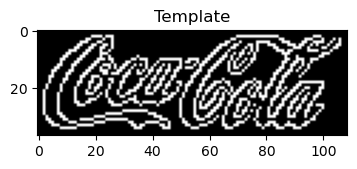

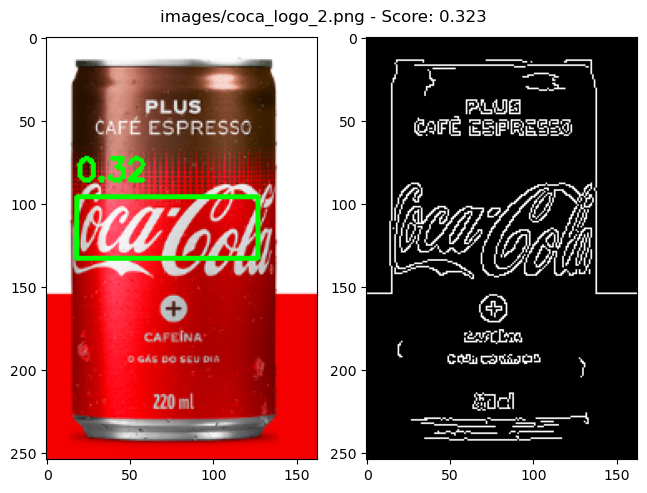

In [5]:
# Detección sobre imagen 2
detect(image_files[1], template_scale=0.28, image_scale=0.7, method=cv2.TM_CCORR_NORMED)

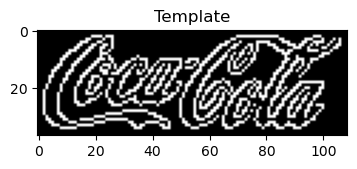

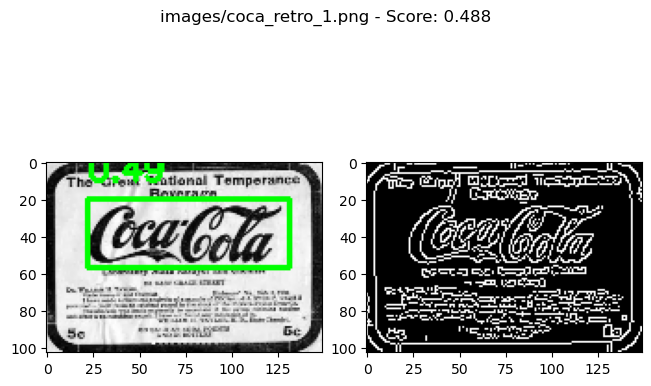

In [6]:
# Detección sobre imagen 3
detect(image_files[2], template_scale=0.28, image_scale=0.209, method=cv2.TM_CCORR_NORMED)

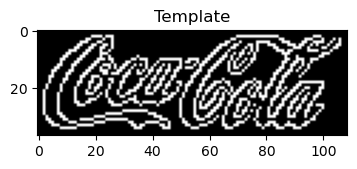

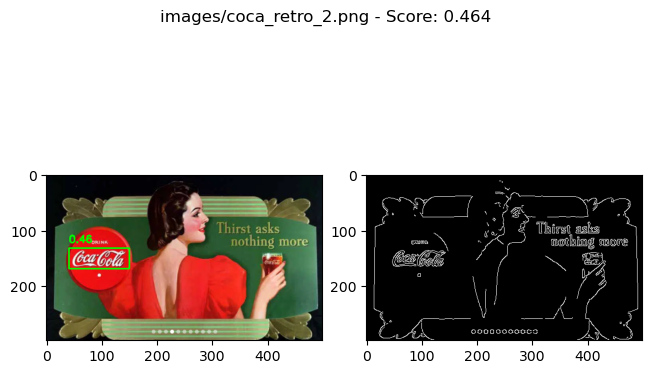

In [7]:
# Detección sobre imagen 4
detect(image_files[3], template_scale=0.28, image_scale=0.696, method=cv2.TM_CCORR_NORMED)

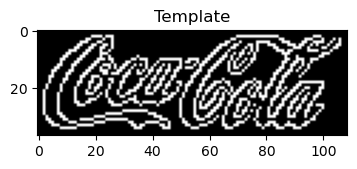

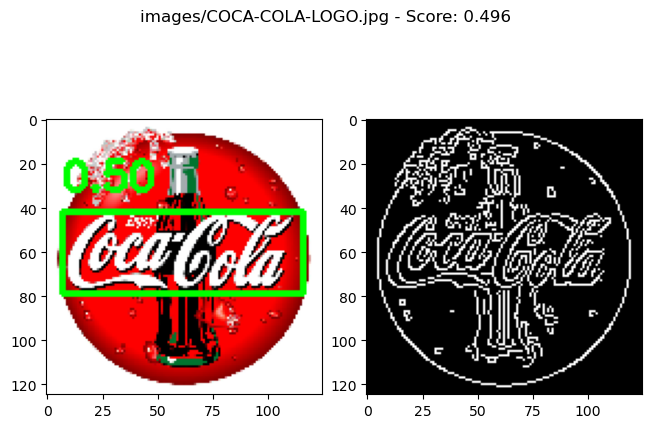

In [8]:
# Detección sobre imagen 5
detect(image_files[4], template_scale=0.28, image_scale=0.09, method=cv2.TM_CCORR_NORMED)

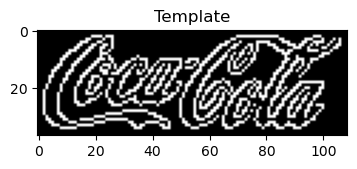

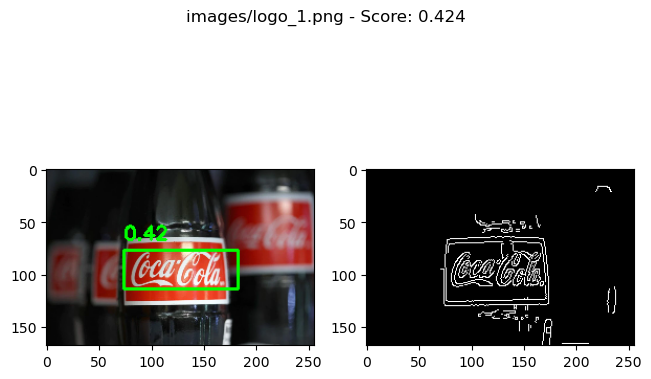

In [9]:
# Detección sobre imagen 6
detect(image_files[5], template_scale=0.28, image_scale=0.373, method=cv2.TM_CCORR_NORMED)

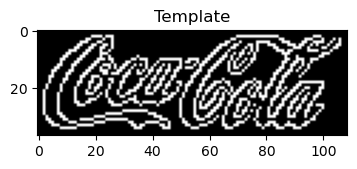

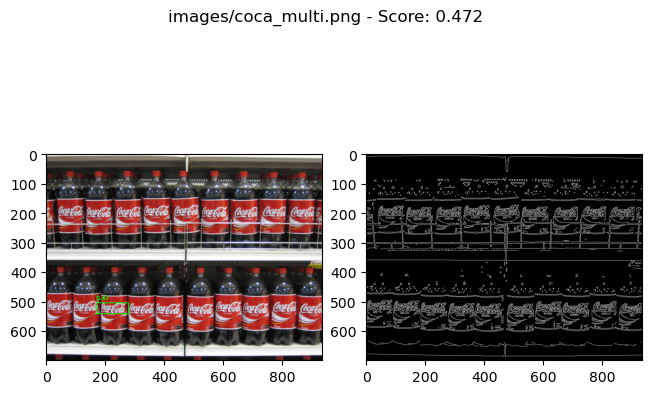

In [10]:
# Detección sobre imagen 7
detect(image_files[6], template_scale=0.28, image_scale=1.17, method=cv2.TM_CCORR_NORMED)

# 💻 TP3 - Parte 2.

(4 puntos) Plantear y validar un algoritmo para múltiples detecciones en la imagen coca_multi.png con el mismo témplate del ítem 1.

In [11]:
def detect_multi(image_file: str, template_scale: float=1., image_scale: float=1., method: int=cv2.TM_CCORR_NORMED):
    # Threshold de score
    threshold = 0.40  # Solo con un valor bajo se consiguio detecciones
    all_rects = []
    all_scores = []

    # Aplicamos resize al template
    template_resized = cv2.resize(template, None, fx=template_scale, fy=template_scale)
    # Aplicamos Canny al template redimensionado
    template_canny = cv2.Canny(template_resized, 50, 100)
    # Recortamos del template el espacio "vacio" (ajustamos el template al contenido)
    coords = cv2.findNonZero(template_canny) # Find all non-zero points
    x, y, w, h = cv2.boundingRect(coords) # Find minimum spanning bounding box
    p = 2 # Padding alrededor del template (para probar)
    template_canny = template_canny[y-p:y+h+p, x-p:x+w+p]
    tH, tW = template_canny.shape[:2] # Dimensión final del template
    # Graficamos el template
    plt.figure(figsize=(4, 3))
    plt.imshow(template_canny, cmap="gray")
    plt.title("Template")
    plt.show()

    # Cargamos la imagen
    img = cv2.imread(image_file)
    # Verificamos las relación respecto al template
    scale_x = template_resized.shape[1] / img.shape[1]
    scale_y = template_resized.shape[0] / img.shape[0]
    # Valor mayor a 1 indica que el template es mas grande que la imagen en algún sentido
    scale_img = max(scale_x, scale_y)
    # Por mas que se indique por parámetro, no podemos ajustar mas allá del tamaño del template
    scale_img = max(scale_img, image_scale)
    # Reescalo si es necesario, o si es indicado por parámetro
    if (scale_img != 1):
        img = cv2.resize(img, None, fx=scale_img, fy=scale_img)
    # Convertimos a grises
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Aplicamos Canny a la imagen redimensionada
    img_canny = cv2.Canny(img_gray, 200, 300)

    # Aplicamos match template
    result = cv2.matchTemplate(img_canny, template_canny, method)

    # Todas las detecciones sobre el threshold que definimos
    (y_coords, x_coords) = np.where(result <= threshold) if method in [cv2.TM_SQDIFF, cv2.TM_SQDIFF_NORMED] else np.where(result >= threshold)

    for (x, y) in zip(x_coords, y_coords):
        all_rects.append([x, y, x + tW, y + tH])
        all_scores.append(result[y, x])

    # Aplicamos NMS
    boxes = non_max_suppression(np.array(all_rects), probs=np.array(all_scores), overlapThresh=0.3)

    # Dibujamos los bounding boxes
    for (startX, startY, endX, endY) in boxes:
        roi = img_canny[startY:endY, startX:endX]
        if roi.size == 0:
            continue
        score = np.max(cv2.matchTemplate(roi, template_canny, method))
        # score = result[startX, startY]
        cv2.rectangle(img, (startX, startY), (endX, endY), (0, 255, 0), 2)
        cv2.putText(img, f"{score:.2f}", (startX, startY - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

    # Mostramos la imagen final
    fig, axs = plt.subplots(1, 2, constrained_layout=True)
    axs[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axs[1].imshow(img_canny, cmap="gray")
    fig.suptitle(f"{image_file} - Score (mean): {np.mean(all_scores):.3f}")
    # plt.tight_layout()
    plt.show()

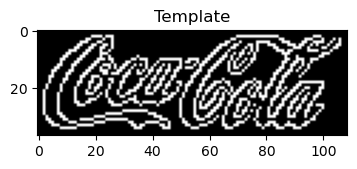

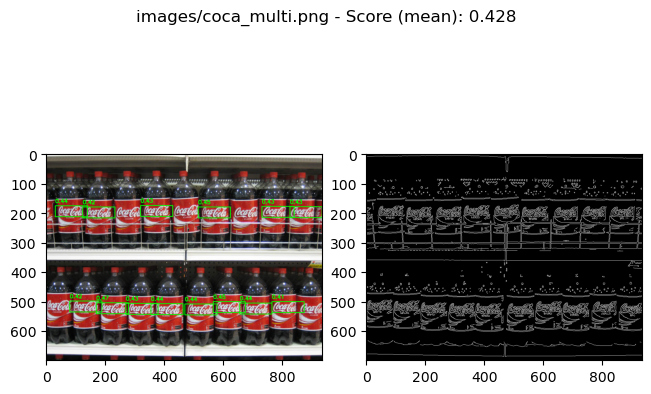

In [12]:
# Detección multiple sobre imagen 7
detect_multi(image_files[6], template_scale=0.28, image_scale=1.17, method=cv2.TM_CCORR_NORMED)

# 💻 TP3 - Parte 3.

(2 puntos) Generalizar el algoritmo del item 2 para todas las imágenes.